<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_08/cats_dogs_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - classifying images from the Dogs vs. Cats Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb

The Dogs vs. Cats dataset is a collection of images for binary image classification. It contains a training set of labeled images of cats and dogs, originally used in a Kaggle competition (2013). Each image is a color photo. The dataset provides a challenging problem of distinguishing between two visually similar categories and is widely used for experimenting with convolutional neural networks.

You can download the dataset from the following sources:
- https://www.kaggle.com/c/dogs-vs-cats
- https://www.microsoft.com/en-us/download/details.aspx?id=54765

We will work with a smaller dataset available at:
- http://zuzka.petricek.net/vyuka_2024/NES2_2024/data/cats_vs_dogs_small.zip

1. Download the zip file with the data
2. Extract the zip file

In [5]:
import requests
import zipfile
import os

zip_path = "cats_vs_dogs_small.zip"
url = "http://zuzka.petricek.net/vyuka_2024/NES2_2024/data/cats_vs_dogs_small.zip"
output_folder = "."

#base_folder ="cats_vs_dogs_small/"

# Download the zip file
response = requests.get(url)

# Save the zip file locally
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(output_folder)

# Clean up by removing the downloaded zip file
os.remove(zip_path)



### The format (structure) of the folder with data:
- the root folder contains three subdirectories: `train` (2000 images), `validation` (1000 images), and `test` (2000 images). The folders represent the essential division of the dataset into training, validation, and testing sets.
- within each of these directories, images for separate classes are stored in distinct subdirectories. This enables Keras to automatically identify class labels based on folder names
- the given format of the folder is required by Keras function `image_dataset_from_directory(directory)`

### Create Datasets from folders
- **`image_dataset_from_directory(directory)`**:
  1. Assumes the folder structure follows the format: class-specific subfolders within `train`, `validation`, and `test` directories.
  2. Scans and indexes image files in each subdirectory, automatically assigning labels based on folder names.
  3. Returns a `tf.data.Dataset` object, configured to:
     - Load and shuffle the files,
     - Decode images into tensors,
     - Resize images to a consistent size,
     - Batch images for efficient model training.

In [27]:
base_folder ="cats_vs_dogs_small/"

from keras.utils import image_dataset_from_directory

image_size = (180, 180)
train_dataset = image_dataset_from_directory(
    base_folder + "train",
    image_size=image_size,
    seed=42,
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_folder  + "validation",
    image_size=image_size,
    seed=42,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_folder  + "test",
    image_size=image_size,
    shuffle = False,
    seed=42,
    batch_size=32)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


- `tf.data.Dataset` is an iterator:

In [28]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break
for data_batch, labels_batch in validation_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
# Another example for dataset:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

# iteration over examples:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

# iteration over batches:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

# iteration over batches with map:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


## Define and train the model

### Simple CNN model for binary classification:
- Start with a keras.Input layer specifying the input shape.
- Add multiple blocks of Conv2D (with 'relu' activation) followed by MaxPooling2D.
- Then add a Flatten layer to convert 2D feature maps to 1D.
- Arbitrary: Include one or more Dense layers with 'relu' (or 'tanh') activations for feature extraction.
- Use 'sigmoid' activation function in the output layer for binary classification.




In [29]:
import keras
from keras import layers
# Define the model architecture
inputs = keras.Input(shape=image_size + (3, ))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │          82,945 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,361 (1.80 MB)

 Trainable params: 471,361 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test Accuracy", "Test Loss", "Train Accuracy", "Train Loss"]
results_df = pd.DataFrame(columns=columns)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │          82,945 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,361 (1.80 MB)

 Trainable params: 471,361 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.4882 - loss: 0.7444 - val_accuracy: 0.6290 - val_loss: 0.6805
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5550 - loss: 0.6896 - val_accuracy: 0.5390 - val_loss: 0.6777
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5874 - loss: 0.6701 - val_accuracy: 0.6080 - val_loss: 0.6415
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.6627 - loss: 0.6228 - val_accuracy: 0.6550 - val_loss: 0.6106
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7082 - loss: 0.5740 - val_accuracy: 0.6200 - val_loss: 0.7901
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7116 - loss: 0.5736 - val_accuracy: 0.6520 - val_loss: 0.6526
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7544 - loss: 0.5035 - val_accuracy: 0.6680 - val_loss: 0.7015
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8037 - loss: 0.4301 - val_accuracy: 0.6660 

<ipython-input-31-387ab1ca7a6e>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


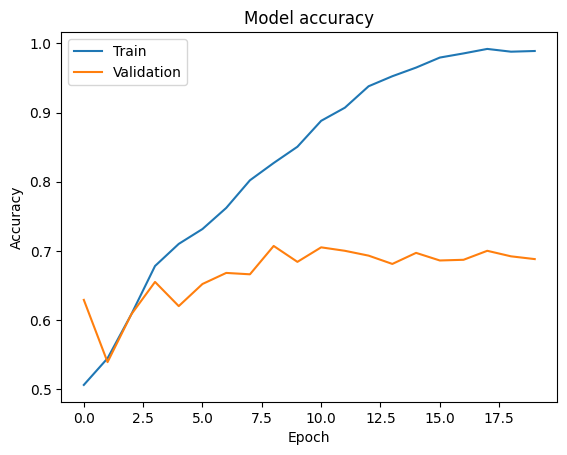

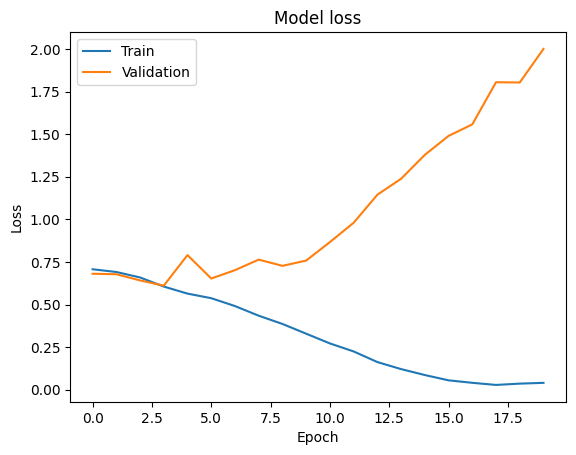

In [31]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "cats_dogs_cnn_"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_cd/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


import keras
from keras import layers
# Define the model architecture
inputs = keras.Input(shape=image_size + (3, ))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.BinaryCrossentropy(),
              metrics= [keras.metrics.BinaryAccuracy("accuracy")])

num_epochs = 20

checkpoint =  keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=[checkpoint, tensorboard_callback])
    #callbacks=[tensorboard_callback, early_stopping])

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_dataset)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

model_details = "basic"
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_cnn_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Confusion matrix and some misclassified images

Predicted labels: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of misclassified images: 618 out of 2000 , accuracy: 0.691


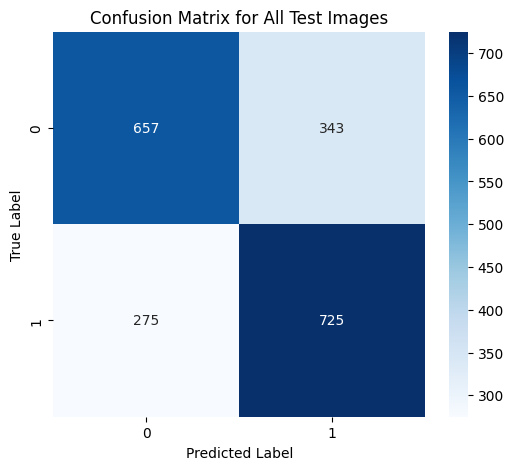

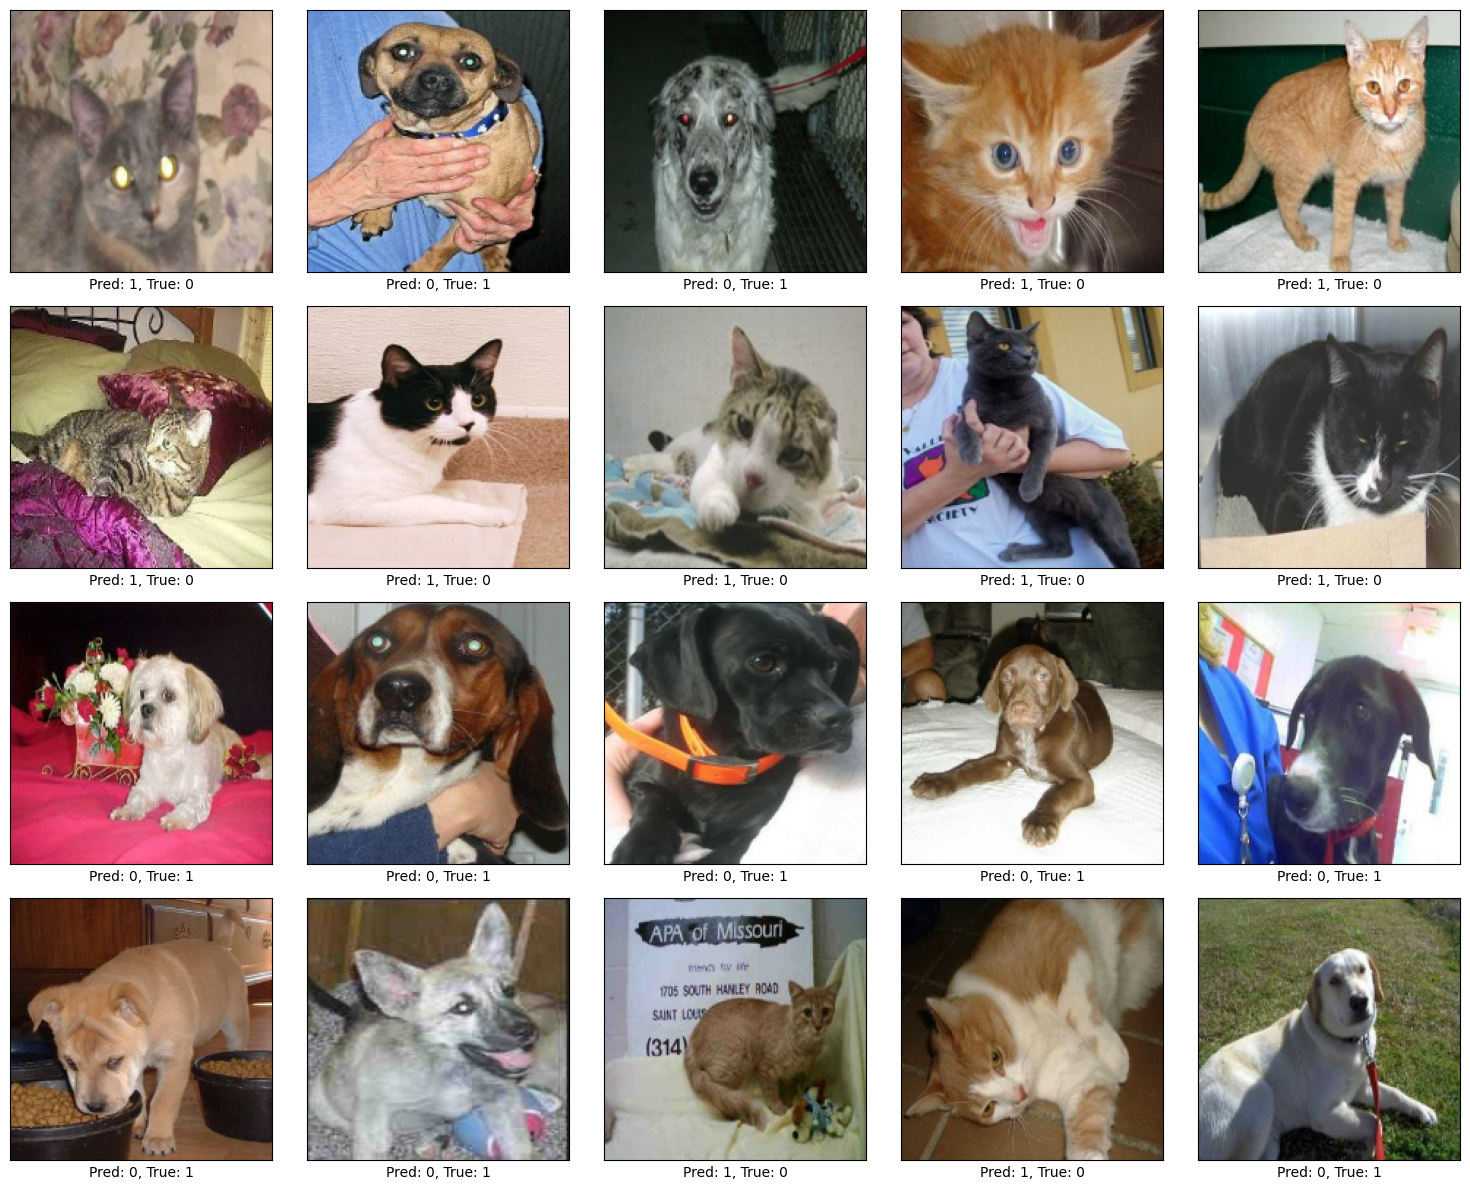

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []


for images, labels in test_dataset:
    preds = model.predict(images, verbose=False)
    preds = tf.round(preds).numpy().flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


    for i in range(len(images)):
        if preds[i] != labels[i].numpy():  # Chybně klasifikováno
            misclassified_images.append(images[i].numpy())
            misclassified_labels.append(labels[i].numpy())
            misclassified_predictions.append(int(preds[i]))

print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
misclassified_images = np.array(misclassified_images)
misclassified_labels = np.array(misclassified_labels)
misclassified_predictions = np.array(misclassified_predictions)

# Calculate the number of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
test_acc = (len(y_true) - num_misclassified) / len(y_true)
print("Number of misclassified images:", num_misclassified,
      "out of", len(y_true), ", accuracy:", test_acc)

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Test Images')
plt.show()

# plot some misclassified images
num_images_to_plot = 20
random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 4 řádky, 5 sloupců
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified_images[index].astype("uint8"))
    plt.xlabel(f"Pred: {misclassified_predictions[index]}, True: {misclassified_labels[index]}")
plt.tight_layout()
plt.show()


## Data augmentation
- Define a data augmentation layer:

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- display some randomly augmented training images

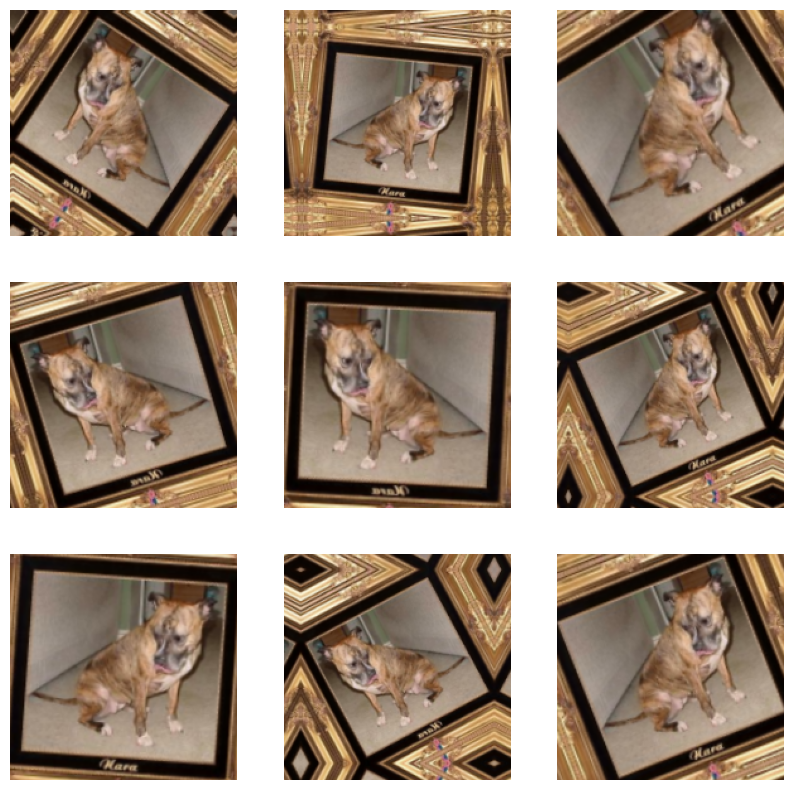

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Train the regularized model

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │          82,945 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,361 (1.80 MB)

 Trainable params: 471,361 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.5120 - loss: 0.7209 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5154 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5102 - loss: 0.6922 - val_accuracy: 0.5190 - val_loss: 0.6881
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5411 - loss: 0.6891 - val_accuracy: 0.5940 - val_loss: 0.6763
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6084 - loss: 0.6701 - val_accuracy: 0.6080 - val_loss: 0.6588
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5915 - loss: 0.6601 - val_accuracy: 0.6540 - val_loss: 0.6279
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6666 - loss: 0.6203 - val_accuracy: 0.6880 - val_loss: 0.5984
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7218 - loss: 0.5744 - val_accuracy: 0.7000 - 

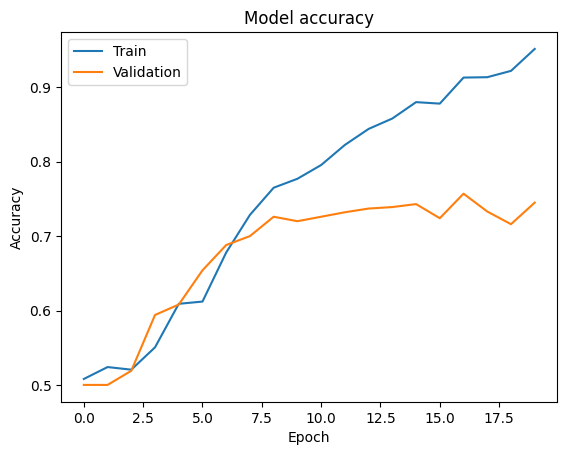

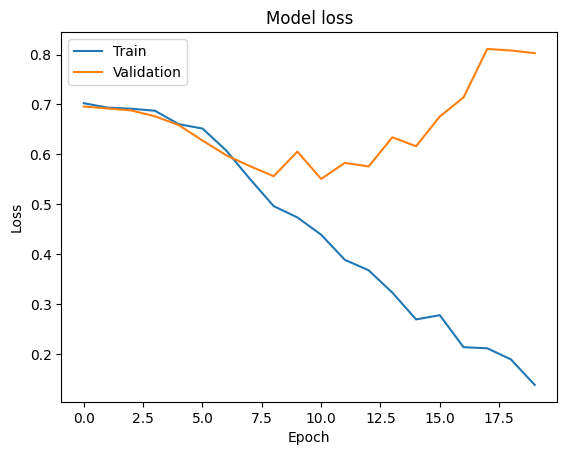

In [37]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "cats_dogs_cnn_augment"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_cd/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


import keras
from keras import layers
# Define the model architecture
inputs = keras.Input(shape=image_size + (3, ))
x = data_augmentation(inputs)             # NEW
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)                # NEW
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.BinaryCrossentropy(),
              metrics= [keras.metrics.BinaryAccuracy("accuracy")])

num_epochs = 20

checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")


early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=[tensorboard_callback, checkpoint])
    #callbacks=[tensorboard_callback, early_stopping])

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_dataset)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

model_details = "augmented"
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_cnn_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Predicted labels: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of misclassified images: 530 out of 2000 , accuracy: 0.735


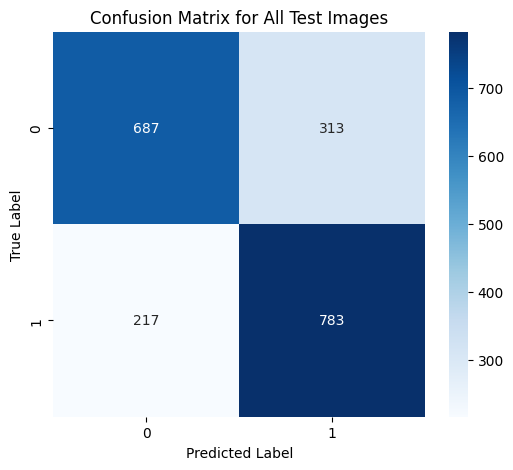

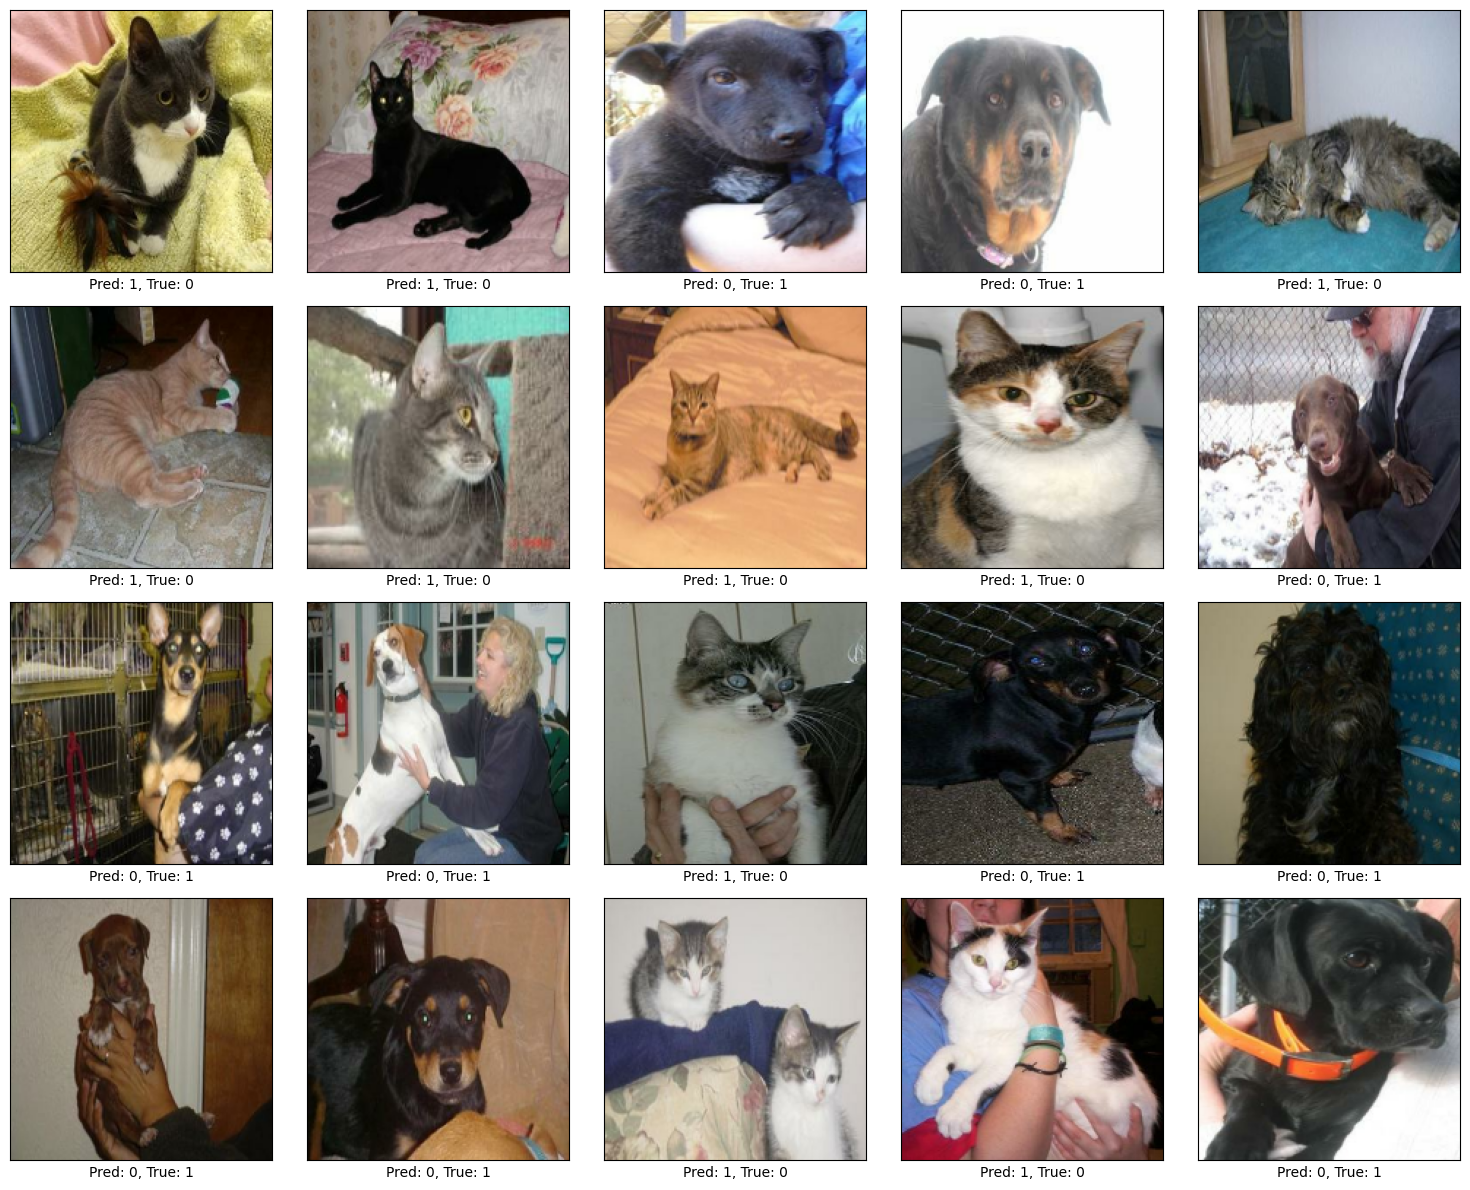

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []


for images, labels in test_dataset:
    preds = model.predict(images, verbose=False)
    preds = tf.round(preds).numpy().flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


    for i in range(len(images)):
        if preds[i] != labels[i].numpy():  # Chybně klasifikováno
            misclassified_images.append(images[i].numpy())
            misclassified_labels.append(labels[i].numpy())
            misclassified_predictions.append(int(preds[i]))

print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
misclassified_images = np.array(misclassified_images)
misclassified_labels = np.array(misclassified_labels)
misclassified_predictions = np.array(misclassified_predictions)

# Calculate the number of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
test_acc = (len(y_true) - num_misclassified) / len(y_true)
print("Number of misclassified images:", num_misclassified,
      "out of", len(y_true), ", accuracy:", test_acc)

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Test Images')
plt.show()

# plot some misclassified images
num_images_to_plot = 20
random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 4 řádky, 5 sloupců
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified_images[index].astype("uint8"))
    plt.xlabel(f"Pred: {misclassified_predictions[index]}, True: {misclassified_labels[index]}")
plt.tight_layout()
plt.show()


In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_cd --reload_interval=1